# Operation-Based Bit Array Fuzzing

In [155]:
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

class BitArrayOperations:
    """
    Operations that can be applied to a bit array.
    Starting from all zeros, n operations should be able to reach any value in [0, 2^n).
    """
    
    @staticmethod
    def flip(bits, pos):
        """Flip bit at position pos"""
        if 0 <= pos < len(bits):
            bits[pos] = 1 - bits[pos]
        return bits
    
    @staticmethod
    def set_bit(bits, pos):
        """Set bit at position pos to 1"""
        if 0 <= pos < len(bits):
            bits[pos] = 1
        return bits
    
    @staticmethod
    def clear_bit(bits, pos):
        """Clear bit at position pos to 0"""
        if 0 <= pos < len(bits):
            bits[pos] = 0
        return bits
    
    @staticmethod
    def shift_left(bits):
        """Shift all bits left by 1, losing leftmost bit"""
        if len(bits) > 0:
            return bits[1:] + [0]
        return bits
    
    @staticmethod
    def shift_right(bits):
        """Shift all bits right by 1, losing rightmost bit"""
        if len(bits) > 0:
            return [0] + bits[:-1]
        return bits
    
    @staticmethod
    def rotate_left(bits):
        """Rotate bits left by 1"""
        if len(bits) > 0:
            return bits[1:] + [bits[0]]
        return bits
    
    @staticmethod
    def rotate_right(bits):
        """Rotate bits right by 1"""
        if len(bits) > 0:
            return [bits[-1]] + bits[:-1]
        return bits
    
    @staticmethod
    def increment(bits):
        """Increment the bit array as a binary number"""
        carry = 1
        for i in range(len(bits) - 1, -1, -1):
            if carry:
                if bits[i] == 0:
                    bits[i] = 1
                    carry = 0
                else:
                    bits[i] = 0
        return bits
    
    @staticmethod
    def decrement(bits):
        """Decrement the bit array as a binary number"""
        borrow = 1
        for i in range(len(bits) - 1, -1, -1):
            if borrow:
                if bits[i] == 1:
                    bits[i] = 0
                    borrow = 0
                else:
                    bits[i] = 1
        return bits

# Operation mapping
OPERATIONS = {
    'flip': BitArrayOperations.flip,
    'set': BitArrayOperations.set_bit,
    'clear': BitArrayOperations.clear_bit,
    'shift_left': BitArrayOperations.shift_left,
    'shift_right': BitArrayOperations.shift_right,
    'rotate_left': BitArrayOperations.rotate_left,
    'rotate_right': BitArrayOperations.rotate_right,
    'increment': BitArrayOperations.increment,
    'decrement': BitArrayOperations.decrement,
}

def apply_operations(operations, n):
    """
    Apply a list of operations to a bit array of size n, starting from all zeros.
    
    Args:
        operations: List of (op_name, arg) tuples. arg is position for positional ops, None otherwise
        n: Size of bit array
    
    Returns:
        Resulting bit array
    """
    bits = [0] * n
    for op_name, arg in operations:
        if op_name in OPERATIONS:
            op_func = OPERATIONS[op_name]
            if arg is not None:
                bits = op_func(bits, arg)
            else:
                bits = op_func(bits)
    return bits

def bits_to_int(bits):
    """Convert bit array to integer"""
    result = 0
    for bit in bits:
        result = (result << 1) | bit
    return result

## Tests

In [156]:
# Test reaching different values
n = 8

# Reach value 5 (binary: 00000101)
ops1 = [('set', 6), ('set', 4)]  # Set positions 6 and 4
result1 = apply_operations(ops1, n)
print(f"Operations {ops1}")
print(f"Result: {result1} -> {bits_to_int(result1)}")

# Reach value 15 using increment (binary: 00001111)
ops2 = [('increment', None)] * 15
result2 = apply_operations(ops2, n)
print(f"\n15 increments")
print(f"Result: {result2} -> {bits_to_int(result2)}")

# Reach value 255 using all sets (binary: 11111111)
ops3 = [('set', i) for i in range(n)]
result3 = apply_operations(ops3, n)
print(f"\nSet all bits")
print(f"Result: {result3} -> {bits_to_int(result3)}")

# Complex sequence
ops4 = [('set', 0), ('shift_left', None), ('set', 7), ('increment', None)]
result4 = apply_operations(ops4, n)
print(f"\nComplex: {ops4}")
print(f"Result: {result4} -> {bits_to_int(result4)}")

Operations [('set', 6), ('set', 4)]
Result: [0, 0, 0, 0, 1, 0, 1, 0] -> 10

15 increments
Result: [0, 0, 0, 0, 1, 1, 1, 1] -> 15

Set all bits
Result: [1, 1, 1, 1, 1, 1, 1, 1] -> 255

Complex: [('set', 0), ('shift_left', None), ('set', 7), ('increment', None)]
Result: [0, 0, 0, 0, 0, 0, 1, 0] -> 2


## Operation-Based Fuzzer

In [157]:
class OperationBasedFuzzer:
    def __init__(self, n=8, max_ops_per_sequence=10, reset_on_drift=False):
        self.n = n  # Bit array size
        self.max_ops = max_ops_per_sequence
        self.reset_on_drift = reset_on_drift  # Whether to reset corpus on drift
        self.coverage = set()  # Track unique values reached
        self.corpus = []  # Store operation sequences that found new coverage
        self.iterations = []
        self.coverage_over_time = []
        self.plateau_threshold = 100  # Iterations without improvement = plateau
        
        # Concept drift detection
        self.window_size = 100  # Window for drift detection
        self.drift_threshold = 0.05  # KS test p-value threshold
        self.value_history = []  # Track discovered values over time
        self.coverage_rate_history = []  # Track coverage rate over time
        self.drift_points = []  # Store (iteration, drift_type) tuples
        self.corpus_resets = []  # Track when corpus was reset
        self.last_window_values = []
        self.last_window_coverage_rates = []
        
        # Operation names that need position argument
        self.positional_ops = {'flip', 'set', 'clear'}
        self.non_positional_ops = {'shift_left', 'shift_right', 'rotate_left', 
                                   'rotate_right', 'increment', 'decrement'}
        
    def generate_random_operation(self):
        """Generate a single random operation"""
        # Choose operation type
        all_ops = list(self.positional_ops | self.non_positional_ops)
        op_name = random.choice(all_ops)
        
        # Generate argument if needed
        if op_name in self.positional_ops:
            arg = random.randint(0, self.n - 1)
        else:
            arg = None
            
        return (op_name, arg)
    
    def generate_random_sequence(self):
        """Generate a random sequence of operations"""
        num_ops = random.randint(1, self.max_ops)
        return [self.generate_random_operation() for _ in range(num_ops)]
    
    def mutate_sequence(self, ops):
        """Mutate an operation sequence (keeping constant length)"""
        mutated = ops.copy()
        mutation_type = random.choice(['modify', 'swap'])
        
        if mutation_type == 'modify' and len(mutated) > 0:
            # Modify a random operation
            pos = random.randint(0, len(mutated) - 1)
            mutated[pos] = self.generate_random_operation()
            
        elif mutation_type == 'swap' and len(mutated) > 1:
            # Swap two operations
            pos1 = random.randint(0, len(mutated) - 1)
            pos2 = random.randint(0, len(mutated) - 1)
            mutated[pos1], mutated[pos2] = mutated[pos2], mutated[pos1]
        
        return mutated
    
    def evaluate_sequence(self, ops):
        """Apply operations and return the resulting value"""
        bits = apply_operations(ops, self.n)
        value = bits_to_int(bits)
        return value, bits
    
    def is_coverage_rate_increasing(self):
        """
        Check if coverage rate is increasing compared to the past window.
        Returns True if current window has higher average coverage rate than previous window.
        """
        if len(self.coverage_rate_history) < self.window_size * 2:
            return True  # Not enough data, assume increasing
        
        # Get current and previous windows
        current_window_start = len(self.coverage_rate_history) - self.window_size
        previous_window_start = current_window_start - self.window_size
        
        current_rates = self.coverage_rate_history[current_window_start:]
        previous_rates = self.coverage_rate_history[previous_window_start:current_window_start]
        
        # Compare average coverage rates
        avg_current = np.mean(current_rates)
        avg_previous = np.mean(previous_rates)
        
        return avg_current > avg_previous
    
    def detect_concept_drift(self, current_iter):
        """
        Detect concept drift using KS test on two types of data:
        1. Value distribution drift
        2. Coverage rate drift
        """
        if len(self.value_history) < self.window_size * 2:
            return  # Not enough data yet
        
        # Get current and previous windows
        current_window_start = len(self.value_history) - self.window_size
        previous_window_start = current_window_start - self.window_size
        
        current_values = self.value_history[current_window_start:]
        previous_values = self.value_history[previous_window_start:current_window_start]
        
        current_coverage_rates = self.coverage_rate_history[current_window_start:]
        previous_coverage_rates = self.coverage_rate_history[previous_window_start:current_window_start]
        
        # KS test for value distribution
        ks_stat_values, p_value_values = stats.ks_2samp(previous_values, current_values)
        
        # KS test for coverage rate
        ks_stat_coverage, p_value_coverage = stats.ks_2samp(
            previous_coverage_rates, current_coverage_rates
        )
        
        # Detect drift if p-value is below threshold (only value distribution)
        if p_value_values < self.drift_threshold:
            self.drift_points.append((current_iter, 'value_distribution'))
            print(f"Iter {current_iter:5d}: CONCEPT DRIFT DETECTED (value_distribution) | "
                  f"KS p-value: {p_value_values:.4f}")
            
            # Check if coverage rate is increasing
            is_increasing = self.is_coverage_rate_increasing()
            print(f"Iter {current_iter:5d}: Coverage rate increasing: {is_increasing}")
            
            # Reset corpus if option is enabled AND coverage rate is not increasing
            if self.reset_on_drift and not is_increasing:
                old_corpus_size = len(self.corpus)
                self.corpus = []
                self.corpus_resets.append(current_iter)
                print(f"Iter {current_iter:5d}: CORPUS RESET - Cleared {old_corpus_size} sequences "
                      f"(coverage rate not increasing)")
            elif self.reset_on_drift and is_increasing:
                print(f"Iter {current_iter:5d}: NO RESET - Coverage rate is increasing, keeping corpus")

    
    def fuzz(self, iterations=5000, random_seed=42):
        """Run the fuzzing campaign"""
        # Reset random seed for reproducibility
        random.seed(random_seed)
        np.random.seed(random_seed)
        
        print(f"Starting operation-based fuzzing for {iterations} iterations...")
        print(f"Bit array size: {self.n}, Max operations per sequence: {self.max_ops}")
        print(f"Target: Discover all values in [0, {2**self.n})")
        print(f"Concept drift detection: Window size={self.window_size}, "
              f"KS threshold p-value={self.drift_threshold}")
        print(f"Corpus reset on drift: {self.reset_on_drift}")
        print(f"Random seed: {random_seed}")
        print("-" * 70)
        
        iterations_since_improvement = 0
        
        for i in range(iterations):
            # Choose generation strategy
            if not self.corpus or random.random() < 0.3:
                # 30% random generation
                ops = self.generate_random_sequence()
            else:
                # 70% mutate from corpus
                seed_ops = random.choice(self.corpus)
                ops = self.mutate_sequence(seed_ops)
            
            # Evaluate the sequence
            value, bits = self.evaluate_sequence(ops)
            
            # Track value and coverage rate for drift detection
            self.value_history.append(value)
            current_coverage_rate = len(self.coverage) / (i + 1) if i > 0 else 0
            self.coverage_rate_history.append(current_coverage_rate)
            
            # Check for new coverage
            is_new = value not in self.coverage
            if is_new:
                self.coverage.add(value)
                self.corpus.append(ops)
                iterations_since_improvement = 0
                
                # Report progress periodically
                if len(self.coverage) % 10 == 0:
                    print(f"Iter {i:5d}: Coverage {len(self.coverage):3d}/{2**self.n} "
                          f"({100*len(self.coverage)/2**self.n:.1f}%) | "
                          f"Found value {value}")
            else:
                iterations_since_improvement += 1
            
            # Track metrics
            self.iterations.append(i)
            self.coverage_over_time.append(len(self.coverage))
            
            # Detect concept drift every window_size iterations
            if (i + 1) % self.window_size == 0:
                self.detect_concept_drift(i)
            
            # Detect plateau
            if iterations_since_improvement > 0 and iterations_since_improvement % self.plateau_threshold == 0:
                print(f"Iter {i:5d}: PLATEAU - No improvement for {iterations_since_improvement} iterations "
                      f"(Coverage: {len(self.coverage)}/{2**self.n})")
        
        print("-" * 70)
        print(f"Fuzzing complete!")
        print(f"Total coverage: {len(self.coverage)}/{2**self.n} values "
              f"({100*len(self.coverage)/2**self.n:.1f}%)")
        print(f"Corpus size: {len(self.corpus)}")
        print(f"Concept drifts detected: {len(self.drift_points)}")
        if self.reset_on_drift:
            print(f"Corpus resets: {len(self.corpus_resets)}")
        
        # Show what values are missing
        all_values = set(range(2**self.n))
        missing = sorted(all_values - self.coverage)
        if missing:
            print(f"\nMissing values ({len(missing)}): {missing[:20]}{'...' if len(missing) > 20 else ''}")
    
    def plot_coverage(self):
        """Visualize coverage growth over time with drift detection markers"""
        plt.figure(figsize=(12, 6))
        plt.plot(self.iterations, self.coverage_over_time, linewidth=2, color='darkblue')
        plt.axhline(y=2**self.n, color='red', linestyle='--', alpha=0.5, 
                   label=f'Maximum possible ({2**self.n})')
        
        # Mark concept drift points (value distribution only)
        if self.drift_points:
            value_drift_iters = [i for i, t in self.drift_points if t == 'value_distribution']
            
            if value_drift_iters:
                value_drift_coverage = [self.coverage_over_time[i] for i in value_drift_iters]
                plt.scatter(value_drift_iters, value_drift_coverage, 
                           color='orange', s=150, marker='^', zorder=5, 
                           label='Value Distribution Drift', alpha=0.8, edgecolors='black')
        
        # Mark corpus resets
        if self.reset_on_drift and self.corpus_resets:
            reset_coverage = [self.coverage_over_time[i] for i in self.corpus_resets]
            plt.scatter(self.corpus_resets, reset_coverage,
                       color='red', s=150, marker='X', zorder=5,
                       label='Corpus Reset', alpha=0.8, edgecolors='black')
        
        plt.xlabel('Iteration', fontsize=12)
        plt.ylabel('Unique Values Discovered', fontsize=12)
        title = 'Coverage Growth with Concept Drift Detection'
        if self.reset_on_drift:
            title += ' (Corpus Reset Enabled)'
        plt.title(title, fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()

Starting operation-based fuzzing for 20000 iterations...
Bit array size: 10, Max operations per sequence: 5
Target: Discover all values in [0, 1024)
Concept drift detection: Window size=100, KS threshold p-value=0.05
Corpus reset on drift: False
Random seed: 42
----------------------------------------------------------------------
Iter    11: Coverage  10/1024 (1.0%) | Found value 4
Iter    48: Coverage  20/1024 (2.0%) | Found value 65
Iter    66: Coverage  30/1024 (2.9%) | Found value 991
Iter   101: Coverage  40/1024 (3.9%) | Found value 959
Iter   133: Coverage  50/1024 (4.9%) | Found value 258
Iter   182: Coverage  60/1024 (5.9%) | Found value 607
Iter   207: Coverage  70/1024 (6.8%) | Found value 894
Iter   258: Coverage  80/1024 (7.8%) | Found value 895
Iter   285: Coverage  90/1024 (8.8%) | Found value 516
Iter   316: Coverage 100/1024 (9.8%) | Found value 132
Iter   349: Coverage 110/1024 (10.7%) | Found value 1021
Iter   397: Coverage 120/1024 (11.7%) | Found value 29
Iter   4

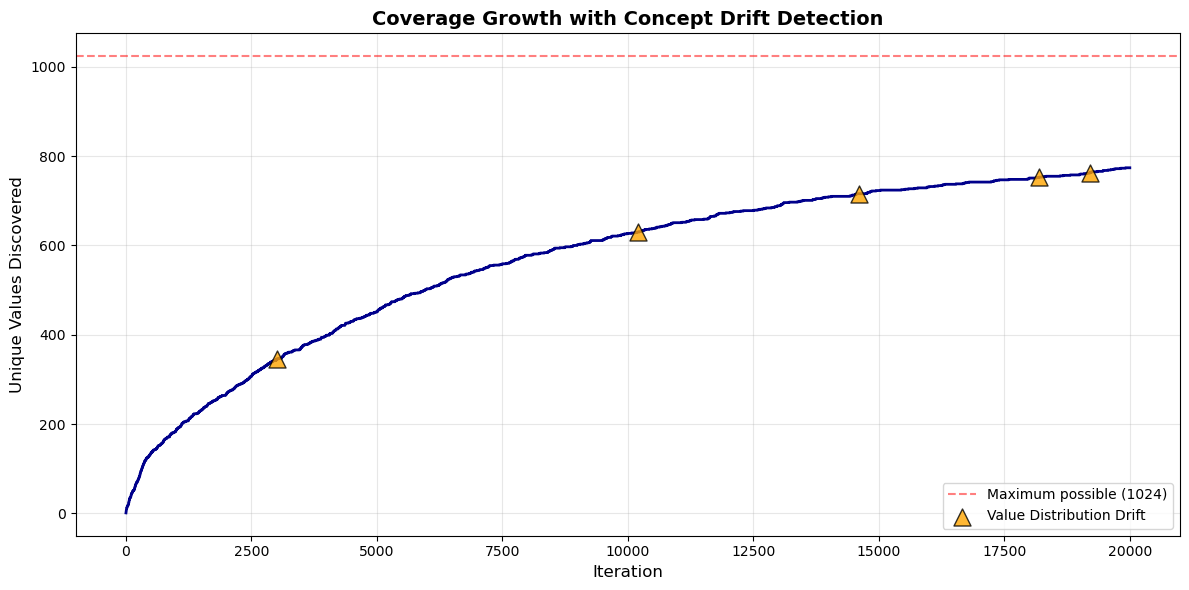

In [158]:
# Run the operation-based fuzzer
fuzzer = OperationBasedFuzzer(n=10, max_ops_per_sequence=5)
fuzzer.fuzz(iterations=20000)
fuzzer.plot_coverage()

## Comparison: With vs Without Corpus Reset

Compare fuzzing performance with and without corpus reset after drift detection:

In [159]:
# Run both versions and compare
print("=" * 80)
print("EXPERIMENT 1: WITHOUT Corpus Reset")
print("=" * 80)
fuzzer_no_reset = OperationBasedFuzzer(n=10, max_ops_per_sequence=5, reset_on_drift=False)
fuzzer_no_reset.fuzz(iterations=20000)

print("\n\n")
print("=" * 80)
print("EXPERIMENT 2: WITH Corpus Reset on Drift")
print("=" * 80)
fuzzer_with_reset = OperationBasedFuzzer(n=10, max_ops_per_sequence=5, reset_on_drift=True)
fuzzer_with_reset.fuzz(iterations=20000)

EXPERIMENT 1: WITHOUT Corpus Reset
Starting operation-based fuzzing for 20000 iterations...
Bit array size: 10, Max operations per sequence: 5
Target: Discover all values in [0, 1024)
Concept drift detection: Window size=100, KS threshold p-value=0.05
Corpus reset on drift: False
Random seed: 42
----------------------------------------------------------------------
Iter    11: Coverage  10/1024 (1.0%) | Found value 4
Iter    48: Coverage  20/1024 (2.0%) | Found value 65
Iter    66: Coverage  30/1024 (2.9%) | Found value 991
Iter   101: Coverage  40/1024 (3.9%) | Found value 959
Iter   133: Coverage  50/1024 (4.9%) | Found value 258
Iter   182: Coverage  60/1024 (5.9%) | Found value 607
Iter   207: Coverage  70/1024 (6.8%) | Found value 894
Iter   258: Coverage  80/1024 (7.8%) | Found value 895
Iter   285: Coverage  90/1024 (8.8%) | Found value 516
Iter   316: Coverage 100/1024 (9.8%) | Found value 132
Iter   349: Coverage 110/1024 (10.7%) | Found value 1021
Iter   397: Coverage 120/102

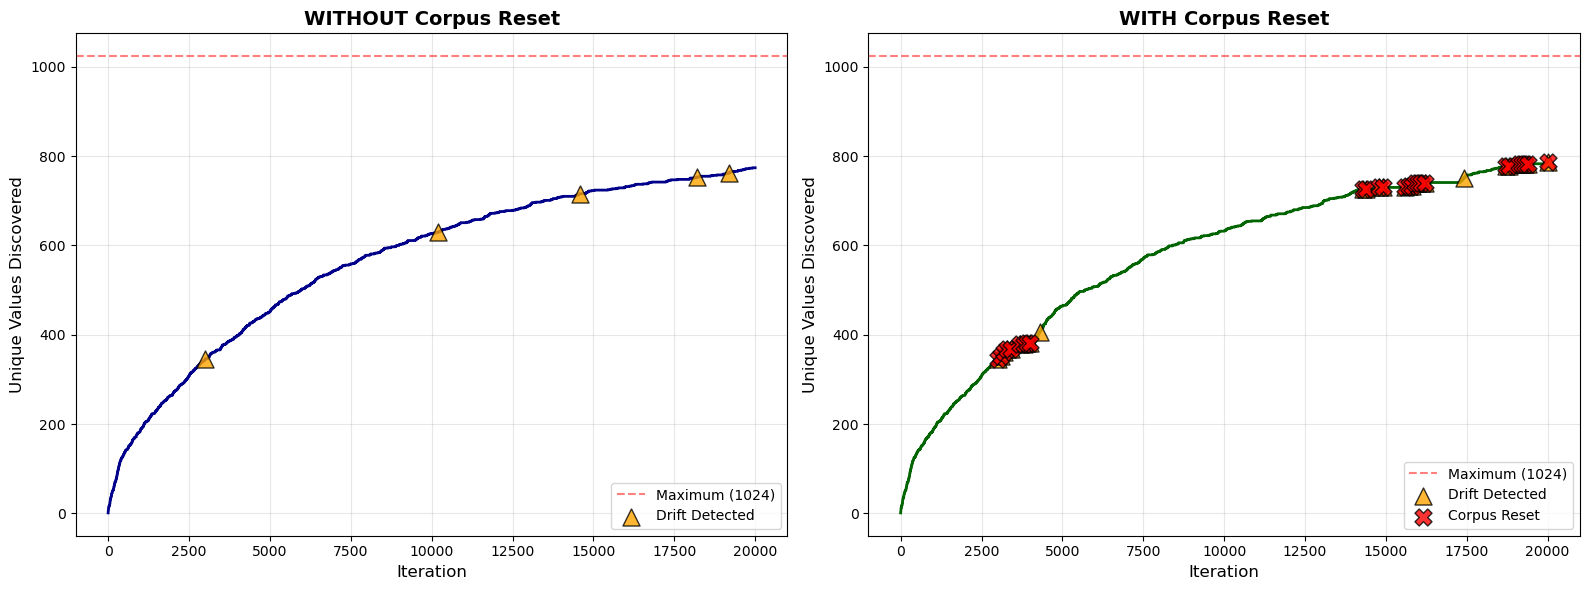


COMPARISON SUMMARY
Without Reset - Final Coverage: 774/1024 (75.6%)
With Reset    - Final Coverage: 788/1024 (77.0%)

Drifts detected: No Reset=5, With Reset=29
Corpus resets performed: 27

Final corpus size: No Reset=774, With Reset=0

Coverage difference: +14 values (better with reset)


In [160]:
# Side-by-side comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Without reset
ax1.plot(fuzzer_no_reset.iterations, fuzzer_no_reset.coverage_over_time, 
         linewidth=2, color='darkblue')
ax1.axhline(y=2**fuzzer_no_reset.n, color='red', linestyle='--', alpha=0.5, 
           label=f'Maximum ({2**fuzzer_no_reset.n})')
if fuzzer_no_reset.drift_points:
    drift_iters = [i for i, t in fuzzer_no_reset.drift_points]
    drift_coverage = [fuzzer_no_reset.coverage_over_time[i] for i in drift_iters]
    ax1.scatter(drift_iters, drift_coverage, color='orange', s=150, marker='^', 
               zorder=5, label='Drift Detected', alpha=0.8, edgecolors='black')
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Unique Values Discovered', fontsize=12)
ax1.set_title('WITHOUT Corpus Reset', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: With reset
ax2.plot(fuzzer_with_reset.iterations, fuzzer_with_reset.coverage_over_time, 
         linewidth=2, color='darkgreen')
ax2.axhline(y=2**fuzzer_with_reset.n, color='red', linestyle='--', alpha=0.5, 
           label=f'Maximum ({2**fuzzer_with_reset.n})')
if fuzzer_with_reset.drift_points:
    drift_iters = [i for i, t in fuzzer_with_reset.drift_points]
    drift_coverage = [fuzzer_with_reset.coverage_over_time[i] for i in drift_iters]
    ax2.scatter(drift_iters, drift_coverage, color='orange', s=150, marker='^', 
               zorder=5, label='Drift Detected', alpha=0.8, edgecolors='black')
if fuzzer_with_reset.corpus_resets:
    reset_coverage = [fuzzer_with_reset.coverage_over_time[i] for i in fuzzer_with_reset.corpus_resets]
    ax2.scatter(fuzzer_with_reset.corpus_resets, reset_coverage, color='red', 
               s=150, marker='X', zorder=5, label='Corpus Reset', alpha=0.8, edgecolors='black')
ax2.set_xlabel('Iteration', fontsize=12)
ax2.set_ylabel('Unique Values Discovered', fontsize=12)
ax2.set_title('WITH Corpus Reset', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Print comparison summary
print("\n" + "=" * 80)
print("COMPARISON SUMMARY")
print("=" * 80)
print(f"Without Reset - Final Coverage: {len(fuzzer_no_reset.coverage)}/{2**fuzzer_no_reset.n} "
      f"({100*len(fuzzer_no_reset.coverage)/2**fuzzer_no_reset.n:.1f}%)")
print(f"With Reset    - Final Coverage: {len(fuzzer_with_reset.coverage)}/{2**fuzzer_with_reset.n} "
      f"({100*len(fuzzer_with_reset.coverage)/2**fuzzer_with_reset.n:.1f}%)")
print(f"\nDrifts detected: No Reset={len(fuzzer_no_reset.drift_points)}, "
      f"With Reset={len(fuzzer_with_reset.drift_points)}")
print(f"Corpus resets performed: {len(fuzzer_with_reset.corpus_resets)}")
print(f"\nFinal corpus size: No Reset={len(fuzzer_no_reset.corpus)}, "
      f"With Reset={len(fuzzer_with_reset.corpus)}")

improvement = len(fuzzer_with_reset.coverage) - len(fuzzer_no_reset.coverage)
print(f"\nCoverage difference: {improvement:+d} values "
      f"({'better' if improvement > 0 else 'worse'} with reset)")

## Multi-Seed Experiment

Run both strategies across 20 different random seeds and compare statistical performance:

In [161]:
import pandas as pd

def run_multi_seed_experiment(n_seeds=20, n_bits=10, max_ops=5, n_iterations=20000, verbose=True):
    """
    Run fuzzing experiment across multiple random seeds comparing with/without corpus reset.
    
    Args:
        n_seeds: Number of different random seeds to test
        n_bits: Size of bit array
        max_ops: Maximum operations per sequence
        n_iterations: Number of fuzzing iterations per run
        verbose: Whether to print progress
        
    Returns:
        pandas.DataFrame with results for each seed
    """
    results = []
    
    if verbose:
        print("=" * 80)
        print(f"Running Multi-Seed Experiment: {n_seeds} seeds")
        print(f"Parameters: n_bits={n_bits}, max_ops={max_ops}, iterations={n_iterations}")
        print("=" * 80)
    
    for seed in range(n_seeds):
        if verbose:
            print(f"\nSeed {seed + 1}/{n_seeds}: {seed}")
            print("-" * 40)
        
        # Run WITHOUT reset
        fuzzer_no_reset = OperationBasedFuzzer(n=n_bits, max_ops_per_sequence=max_ops, reset_on_drift=False)
        fuzzer_no_reset.fuzz(iterations=n_iterations, random_seed=seed)
        
        # Run WITH reset
        fuzzer_with_reset = OperationBasedFuzzer(n=n_bits, max_ops_per_sequence=max_ops, reset_on_drift=True)
        fuzzer_with_reset.fuzz(iterations=n_iterations, random_seed=seed)
        
        # Store results
        results.append({
            'seed': seed,
            'no_reset_coverage': len(fuzzer_no_reset.coverage),
            'with_reset_coverage': len(fuzzer_with_reset.coverage),
            'no_reset_drifts': len(fuzzer_no_reset.drift_points),
            'with_reset_drifts': len(fuzzer_with_reset.drift_points),
            'corpus_resets': len(fuzzer_with_reset.corpus_resets),
            'no_reset_corpus_size': len(fuzzer_no_reset.corpus),
            'with_reset_corpus_size': len(fuzzer_with_reset.corpus),
            'coverage_diff': len(fuzzer_with_reset.coverage) - len(fuzzer_no_reset.coverage)
        })
        
        if verbose:
            print(f"  No Reset:   Coverage={len(fuzzer_no_reset.coverage)}/{2**n_bits}")
            print(f"  With Reset: Coverage={len(fuzzer_with_reset.coverage)}/{2**n_bits}")
            print(f"  Difference: {results[-1]['coverage_diff']:+d}")
    
    # Create DataFrame
    df_results = pd.DataFrame(results)
    
    if verbose:
        print("\n" + "=" * 80)
        print("EXPERIMENT COMPLETE")
        print("=" * 80)
    
    return df_results

# Run the experiment
df_results = run_multi_seed_experiment(n_seeds=20, n_bits=10, max_ops=5, n_iterations=20000)

Running Multi-Seed Experiment: 20 seeds
Parameters: n_bits=10, max_ops=5, iterations=20000

Seed 1/20: 0
----------------------------------------
Starting operation-based fuzzing for 20000 iterations...
Bit array size: 10, Max operations per sequence: 5
Target: Discover all values in [0, 1024)
Concept drift detection: Window size=100, KS threshold p-value=0.05
Corpus reset on drift: False
Random seed: 0
----------------------------------------------------------------------
Iter    19: Coverage  10/1024 (1.0%) | Found value 64
Iter    49: Coverage  20/1024 (2.0%) | Found value 8
Iter    79: Coverage  30/1024 (2.9%) | Found value 128
Iter   125: Coverage  40/1024 (3.9%) | Found value 33
Iter   179: Coverage  50/1024 (4.9%) | Found value 991
Iter   239: Coverage  60/1024 (5.9%) | Found value 24
Iter   268: Coverage  70/1024 (6.8%) | Found value 12
Iter   304: Coverage  80/1024 (7.8%) | Found value 544
Iter   354: Coverage  90/1024 (8.8%) | Found value 527
Iter   426: Coverage 100/1024 (9.

In [162]:
# Display results table
def print_experiment_summary(df_results, n_bits=10):
    """
    Print detailed summary of multi-seed experiment results.
    
    Args:
        df_results: DataFrame with experiment results
        n_bits: Number of bits (for calculating percentages)
    """
    n_seeds = len(df_results)
    
    print("\nDETAILED RESULTS TABLE")
    print("=" * 80)
    
    # Format the table nicely
    pd.set_option('display.max_rows', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_columns', None)
    
    # Create display columns
    display_df = df_results[[
        'seed', 
        'no_reset_coverage', 
        'with_reset_coverage', 
        'coverage_diff',
        'no_reset_drifts',
        'with_reset_drifts',
        'corpus_resets'
    ]].copy()
    
    display_df.columns = [
        'Seed', 
        'No Reset Cov', 
        'With Reset Cov', 
        'Diff',
        'Drifts (No)', 
        'Drifts (Yes)',
        'Resets'
    ]
    
    print(display_df.to_string(index=False))
    
    print("\n" + "=" * 80)
    print("SUMMARY STATISTICS")
    print("=" * 80)
    
    # Calculate summary statistics
    print(f"\nCoverage (No Reset):")
    print(f"  Mean:   {df_results['no_reset_coverage'].mean():.2f}")
    print(f"  Median: {df_results['no_reset_coverage'].median():.2f}")
    print(f"  Std:    {df_results['no_reset_coverage'].std():.2f}")
    print(f"  Min:    {df_results['no_reset_coverage'].min()}")
    print(f"  Max:    {df_results['no_reset_coverage'].max()}")
    
    print(f"\nCoverage (With Reset):")
    print(f"  Mean:   {df_results['with_reset_coverage'].mean():.2f}")
    print(f"  Median: {df_results['with_reset_coverage'].median():.2f}")
    print(f"  Std:    {df_results['with_reset_coverage'].std():.2f}")
    print(f"  Min:    {df_results['with_reset_coverage'].min()}")
    print(f"  Max:    {df_results['with_reset_coverage'].max()}")
    
    print(f"\nCoverage Difference (With Reset - No Reset):")
    print(f"  Mean:   {df_results['coverage_diff'].mean():.2f}")
    print(f"  Median: {df_results['coverage_diff'].median():.2f}")
    print(f"  Std:    {df_results['coverage_diff'].std():.2f}")
    
    # Count wins
    wins_with_reset = (df_results['coverage_diff'] > 0).sum()
    wins_no_reset = (df_results['coverage_diff'] < 0).sum()
    ties = (df_results['coverage_diff'] == 0).sum()
    
    print(f"\nWin Statistics (out of {n_seeds} runs):")
    print(f"  With Reset Better:   {wins_with_reset} ({100*wins_with_reset/n_seeds:.1f}%)")
    print(f"  No Reset Better:     {wins_no_reset} ({100*wins_no_reset/n_seeds:.1f}%)")
    print(f"  Ties:                {ties} ({100*ties/n_seeds:.1f}%)")
    
    print(f"\nCorpus Resets:")
    print(f"  Mean resets per run: {df_results['corpus_resets'].mean():.2f}")
    print(f"  Total resets:        {df_results['corpus_resets'].sum()}")
    
    print(f"\nDrift Detection:")
    print(f"  Mean drifts (No Reset):   {df_results['no_reset_drifts'].mean():.2f}")
    print(f"  Mean drifts (With Reset): {df_results['with_reset_drifts'].mean():.2f}")
    
    # Statistical test
    from scipy import stats as scipy_stats
    t_stat, p_value = scipy_stats.ttest_rel(
        df_results['with_reset_coverage'], 
        df_results['no_reset_coverage']
    )
    
    print(f"\nPaired t-test:")
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value:     {p_value:.4f}")
    if p_value < 0.05:
        if df_results['coverage_diff'].mean() > 0:
            print(f"  Result: With Reset is SIGNIFICANTLY BETTER (p < 0.05)")
        else:
            print(f"  Result: No Reset is SIGNIFICANTLY BETTER (p < 0.05)")
    else:
        print(f"  Result: No significant difference (p >= 0.05)")
    
    print("\n" + "=" * 80)

# Print summary
print_experiment_summary(df_results, n_bits=10)


DETAILED RESULTS TABLE
 Seed  No Reset Cov  With Reset Cov  Diff  Drifts (No)  Drifts (Yes)  Resets
    0           775             796    21            4            52      48
    1           827             853    26            7            41      39
    2           769             697   -72            6            40      39
    3           737             760    23            8            55      51
    4           826             713  -113            9            49      44
    5           750             819    69           12            41      38
    6           758             809    51            5            44      38
    7           775             793    18            7            19      18
    8           775             850    75            7             5       3
    9           807             839    32            3            30      27
   10           763             748   -15           12            48      47
   11           779             821    42           

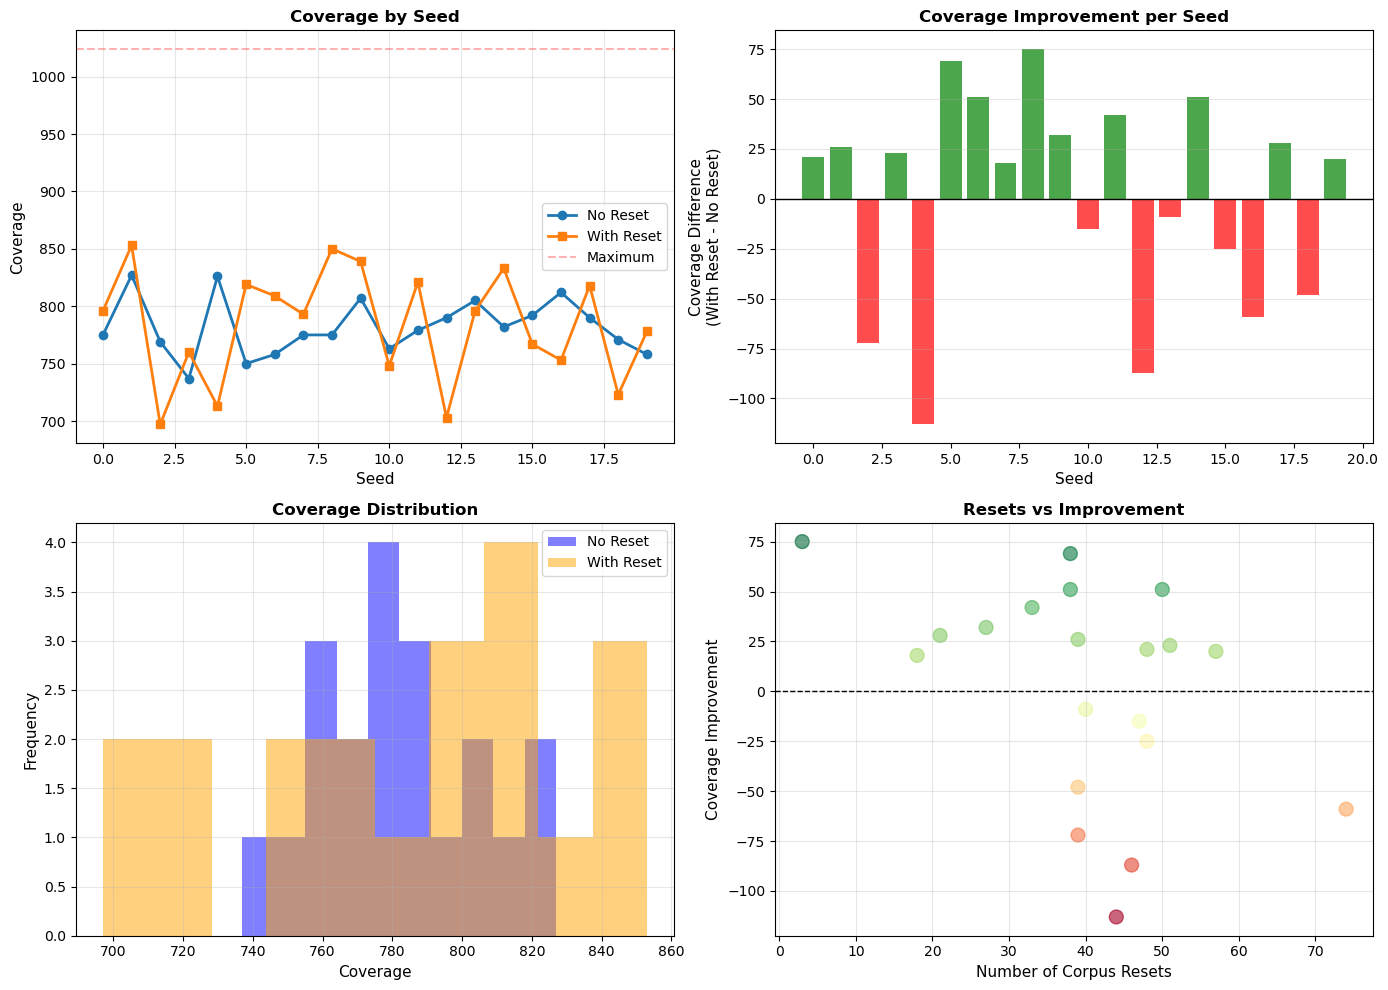


Visualization complete!


In [163]:
# Visualize the results
def plot_experiment_results(df_results, n_bits=10):
    """
    Create visualization plots for multi-seed experiment results.
    
    Args:
        df_results: DataFrame with experiment results
        n_bits: Number of bits (for calculating maximum coverage)
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Coverage comparison
    ax1 = axes[0, 0]
    x = df_results['seed']
    ax1.plot(x, df_results['no_reset_coverage'], marker='o', label='No Reset', linewidth=2)
    ax1.plot(x, df_results['with_reset_coverage'], marker='s', label='With Reset', linewidth=2)
    ax1.axhline(y=2**n_bits, color='red', linestyle='--', alpha=0.3, label='Maximum')
    ax1.set_xlabel('Seed', fontsize=11)
    ax1.set_ylabel('Coverage', fontsize=11)
    ax1.set_title('Coverage by Seed', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Coverage difference
    ax2 = axes[0, 1]
    colors = ['green' if d > 0 else 'red' if d < 0 else 'gray' for d in df_results['coverage_diff']]
    ax2.bar(x, df_results['coverage_diff'], color=colors, alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax2.set_xlabel('Seed', fontsize=11)
    ax2.set_ylabel('Coverage Difference\n(With Reset - No Reset)', fontsize=11)
    ax2.set_title('Coverage Improvement per Seed', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Plot 3: Distribution comparison
    ax3 = axes[1, 0]
    ax3.hist(df_results['no_reset_coverage'], alpha=0.5, bins=10, label='No Reset', color='blue')
    ax3.hist(df_results['with_reset_coverage'], alpha=0.5, bins=10, label='With Reset', color='orange')
    ax3.set_xlabel('Coverage', fontsize=11)
    ax3.set_ylabel('Frequency', fontsize=11)
    ax3.set_title('Coverage Distribution', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Corpus resets vs coverage improvement
    ax4 = axes[1, 1]
    ax4.scatter(df_results['corpus_resets'], df_results['coverage_diff'], 
               s=100, alpha=0.6, c=df_results['coverage_diff'], cmap='RdYlGn')
    ax4.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax4.set_xlabel('Number of Corpus Resets', fontsize=11)
    ax4.set_ylabel('Coverage Improvement', fontsize=11)
    ax4.set_title('Resets vs Improvement', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nVisualization complete!")

# Plot results
plot_experiment_results(df_results, n_bits=10)

In [164]:
df = run_multi_seed_experiment(n_seeds=20, n_bits=12, max_ops=10, n_iterations=20000)

Running Multi-Seed Experiment: 20 seeds
Parameters: n_bits=12, max_ops=10, iterations=20000

Seed 1/20: 0
----------------------------------------
Starting operation-based fuzzing for 20000 iterations...
Bit array size: 12, Max operations per sequence: 10
Target: Discover all values in [0, 4096)
Concept drift detection: Window size=100, KS threshold p-value=0.05
Corpus reset on drift: False
Random seed: 0
----------------------------------------------------------------------
Iter    14: Coverage  10/4096 (0.2%) | Found value 3
Iter    51: Coverage  20/4096 (0.5%) | Found value 63
Iter    71: Coverage  30/4096 (0.7%) | Found value 32
Iter   118: Coverage  40/4096 (1.0%) | Found value 4095
Iter   148: Coverage  50/4096 (1.2%) | Found value 1027
Iter   179: Coverage  60/4096 (1.5%) | Found value 2562
Iter   219: Coverage  70/4096 (1.7%) | Found value 511
Iter   262: Coverage  80/4096 (2.0%) | Found value 2208
Iter   298: Coverage  90/4096 (2.2%) | Found value 2568
Iter   325: Coverage 100


DETAILED RESULTS TABLE
 Seed  No Reset Cov  With Reset Cov  Diff  Drifts (No)  Drifts (Yes)  Resets
    0          2680            2593   -87            7            59      56
    1          2735            3231   496            8            43      40
    2          2731            2927   196           12            45      44
    3          2746            3168   422            5            24      24
    4          2549            3090   541           15            22      21
    5          2752            2874   122            4            58      57
    6          2860            3137   277            8            17      16
    7          2830            3055   225           13             5       5
    8          2805            3056   251            7            53      52
    9          2583            3088   505            6            31      28
   10          2636            2813   177            7            51      49
   11          2641            3033   392           

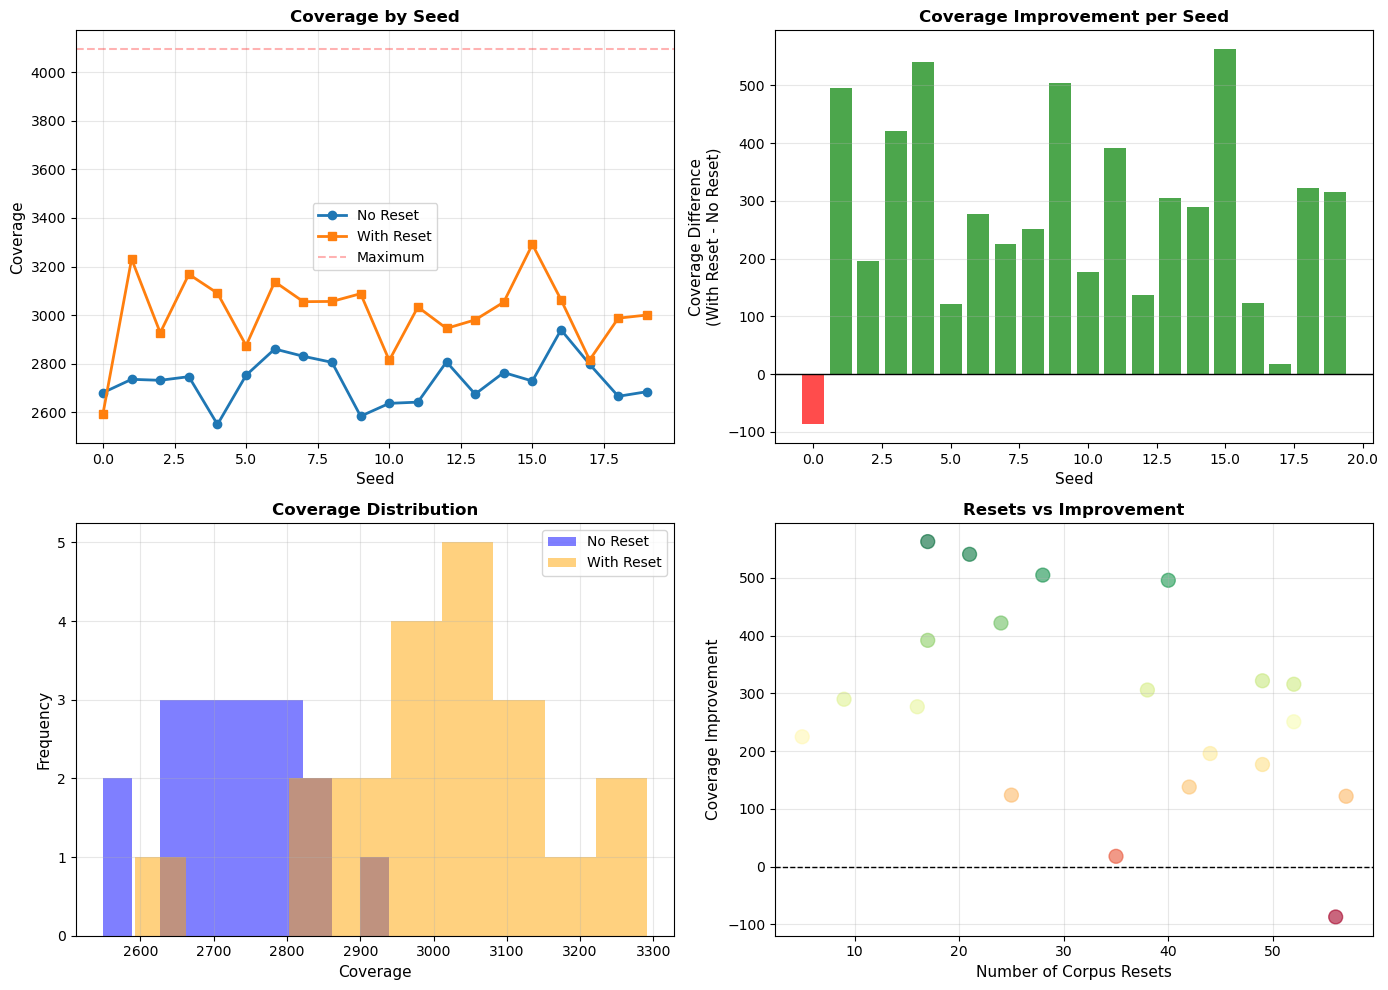


Visualization complete!


In [165]:
print_experiment_summary(df, n_bits=12)
plot_experiment_results(df, n_bits=12)

## Alternative Fuzzer: Coverage Rate Drift Detection

Instead of detecting drift based on value distribution, this fuzzer tracks concept drift by monitoring changes in the coverage rate (coverage/iteration ratio):

In [166]:
class CoverageRateFuzzer:
    """
    Alternative fuzzer that detects concept drift based on coverage rate instead of value distribution.
    Coverage rate = coverage / iteration
    """
    def __init__(self, n=8, max_ops_per_sequence=10, reset_on_drift=False):
        self.n = n  # Bit array size
        self.max_ops = max_ops_per_sequence
        self.reset_on_drift = reset_on_drift  # Whether to reset corpus on drift
        self.coverage = set()  # Track unique values reached
        self.corpus = []  # Store operation sequences that found new coverage
        self.iterations = []
        self.coverage_over_time = []
        self.plateau_threshold = 100  # Iterations without improvement = plateau
        
        # Concept drift detection - using coverage rate
        self.window_size = 100  # Window for drift detection
        self.drift_threshold = 0.05  # KS test p-value threshold
        self.coverage_rate_history = []  # Track coverage rate over time
        self.drift_points = []  # Store (iteration, drift_type) tuples
        self.corpus_resets = []  # Track when corpus was reset
        
        # Operation names that need position argument
        self.positional_ops = {'flip', 'set', 'clear'}
        self.non_positional_ops = {'shift_left', 'shift_right', 'rotate_left', 
                                   'rotate_right', 'increment', 'decrement'}
        
    def generate_random_operation(self):
        """Generate a single random operation"""
        all_ops = list(self.positional_ops | self.non_positional_ops)
        op_name = random.choice(all_ops)
        
        if op_name in self.positional_ops:
            arg = random.randint(0, self.n - 1)
        else:
            arg = None
            
        return (op_name, arg)
    
    def generate_random_sequence(self):
        """Generate a random sequence of operations"""
        num_ops = random.randint(1, self.max_ops)
        return [self.generate_random_operation() for _ in range(num_ops)]
    
    def mutate_sequence(self, ops):
        """Mutate an operation sequence (keeping constant length)"""
        mutated = ops.copy()
        mutation_type = random.choice(['modify', 'swap'])
        
        if mutation_type == 'modify' and len(mutated) > 0:
            pos = random.randint(0, len(mutated) - 1)
            mutated[pos] = self.generate_random_operation()
            
        elif mutation_type == 'swap' and len(mutated) > 1:
            pos1 = random.randint(0, len(mutated) - 1)
            pos2 = random.randint(0, len(mutated) - 1)
            mutated[pos1], mutated[pos2] = mutated[pos2], mutated[pos1]
        
        return mutated
    
    def evaluate_sequence(self, ops):
        """Apply operations and return the resulting value"""
        bits = apply_operations(ops, self.n)
        value = bits_to_int(bits)
        return value, bits
    
    def is_coverage_rate_increasing(self):
        """
        Check if coverage rate is increasing compared to the past window.
        Returns True if current window has higher average coverage rate than previous window.
        """
        if len(self.coverage_rate_history) < self.window_size * 2:
            return True  # Not enough data, assume increasing
        
        # Get current and previous windows
        current_window_start = len(self.coverage_rate_history) - self.window_size
        previous_window_start = current_window_start - self.window_size
        
        current_rates = self.coverage_rate_history[current_window_start:]
        previous_rates = self.coverage_rate_history[previous_window_start:current_window_start]
        
        # Compare average coverage rates
        avg_current = np.mean(current_rates)
        avg_previous = np.mean(previous_rates)
        
        return avg_current > avg_previous
    
    def detect_concept_drift(self, current_iter):
        """
        Detect concept drift using KS test on coverage rate distribution.
        """
        if len(self.coverage_rate_history) < self.window_size * 2:
            return  # Not enough data yet
        
        # Get current and previous windows
        current_window_start = len(self.coverage_rate_history) - self.window_size
        previous_window_start = current_window_start - self.window_size
        
        current_coverage_rates = self.coverage_rate_history[current_window_start:]
        previous_coverage_rates = self.coverage_rate_history[previous_window_start:current_window_start]
        
        # KS test for coverage rate
        ks_stat, p_value = stats.ks_2samp(previous_coverage_rates, current_coverage_rates)
        
        # Detect drift if p-value is below threshold
        if p_value < self.drift_threshold:
            self.drift_points.append((current_iter, 'coverage_rate'))
            print(f"Iter {current_iter:5d}: CONCEPT DRIFT DETECTED (coverage_rate) | "
                  f"KS p-value: {p_value:.4f}")
            
            # Check if coverage rate is increasing
            is_increasing = self.is_coverage_rate_increasing()
            print(f"Iter {current_iter:5d}: Coverage rate increasing: {is_increasing}")
            
            # Reset corpus if option is enabled AND coverage rate is not increasing
            if self.reset_on_drift and not is_increasing:
                old_corpus_size = len(self.corpus)
                self.corpus = []
                self.corpus_resets.append(current_iter)
                print(f"Iter {current_iter:5d}: CORPUS RESET - Cleared {old_corpus_size} sequences "
                      f"(coverage rate not increasing)")
            elif self.reset_on_drift and is_increasing:
                print(f"Iter {current_iter:5d}: NO RESET - Coverage rate is increasing, keeping corpus")

    
    def fuzz(self, iterations=5000, random_seed=42):
        """Run the fuzzing campaign"""
        # Reset random seed for reproducibility
        random.seed(random_seed)
        np.random.seed(random_seed)
        
        print(f"Starting COVERAGE RATE based fuzzing for {iterations} iterations...")
        print(f"Bit array size: {self.n}, Max operations per sequence: {self.max_ops}")
        print(f"Target: Discover all values in [0, {2**self.n})")
        print(f"Concept drift detection: Coverage Rate | Window size={self.window_size}, "
              f"KS threshold p-value={self.drift_threshold}")
        print(f"Corpus reset on drift: {self.reset_on_drift}")
        print(f"Random seed: {random_seed}")
        print("-" * 70)
        
        iterations_since_improvement = 0
        
        for i in range(iterations):
            # Choose generation strategy
            if not self.corpus or random.random() < 0.3:
                # 30% random generation
                ops = self.generate_random_sequence()
            else:
                # 70% mutate from corpus
                seed_ops = random.choice(self.corpus)
                ops = self.mutate_sequence(seed_ops)
            
            # Evaluate the sequence
            value, bits = self.evaluate_sequence(ops)
            
            # Track coverage rate for drift detection
            current_coverage_rate = len(self.coverage) / (i + 1) if i > 0 else 0
            self.coverage_rate_history.append(current_coverage_rate)
            
            # Check for new coverage
            is_new = value not in self.coverage
            if is_new:
                self.coverage.add(value)
                self.corpus.append(ops)
                iterations_since_improvement = 0
                
                # Report progress periodically
                if len(self.coverage) % 10 == 0:
                    print(f"Iter {i:5d}: Coverage {len(self.coverage):3d}/{2**self.n} "
                          f"({100*len(self.coverage)/2**self.n:.1f}%) | "
                          f"Found value {value}")
            else:
                iterations_since_improvement += 1
            
            # Track metrics
            self.iterations.append(i)
            self.coverage_over_time.append(len(self.coverage))
            
            # Detect concept drift every window_size iterations
            if (i + 1) % self.window_size == 0:
                self.detect_concept_drift(i)
            
            # Detect plateau
            if iterations_since_improvement > 0 and iterations_since_improvement % self.plateau_threshold == 0:
                print(f"Iter {i:5d}: PLATEAU - No improvement for {iterations_since_improvement} iterations "
                      f"(Coverage: {len(self.coverage)}/{2**self.n})")
        
        print("-" * 70)
        print(f"Fuzzing complete!")
        print(f"Total coverage: {len(self.coverage)}/{2**self.n} values "
              f"({100*len(self.coverage)/2**self.n:.1f}%)")
        print(f"Corpus size: {len(self.corpus)}")
        print(f"Concept drifts detected: {len(self.drift_points)}")
        if self.reset_on_drift:
            print(f"Corpus resets: {len(self.corpus_resets)}")
        
        # Show what values are missing
        all_values = set(range(2**self.n))
        missing = sorted(all_values - self.coverage)
        if missing:
            print(f"\nMissing values ({len(missing)}): {missing[:20]}{'...' if len(missing) > 20 else ''}")
    
    def plot_coverage(self):
        """Visualize coverage growth over time with drift detection markers"""
        plt.figure(figsize=(12, 6))
        plt.plot(self.iterations, self.coverage_over_time, linewidth=2, color='darkblue')
        plt.axhline(y=2**self.n, color='red', linestyle='--', alpha=0.5, 
                   label=f'Maximum possible ({2**self.n})')
        
        # Mark concept drift points
        if self.drift_points:
            drift_iters = [i for i, t in self.drift_points]
            drift_coverage = [self.coverage_over_time[i] for i in drift_iters]
            plt.scatter(drift_iters, drift_coverage, 
                       color='purple', s=150, marker='^', zorder=5, 
                       label='Coverage Rate Drift', alpha=0.8, edgecolors='black')
        
        # Mark corpus resets
        if self.reset_on_drift and self.corpus_resets:
            reset_coverage = [self.coverage_over_time[i] for i in self.corpus_resets]
            plt.scatter(self.corpus_resets, reset_coverage,
                       color='red', s=150, marker='X', zorder=5,
                       label='Corpus Reset', alpha=0.8, edgecolors='black')
        
        plt.xlabel('Iteration', fontsize=12)
        plt.ylabel('Unique Values Discovered', fontsize=12)
        title = 'Coverage Growth - Coverage Rate Drift Detection'
        if self.reset_on_drift:
            title += ' (Corpus Reset Enabled)'
        plt.title(title, fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()

Testing Coverage Rate Drift Detection Fuzzer
Starting COVERAGE RATE based fuzzing for 20000 iterations...
Bit array size: 10, Max operations per sequence: 5
Target: Discover all values in [0, 1024)
Concept drift detection: Coverage Rate | Window size=100, KS threshold p-value=0.05
Corpus reset on drift: True
Random seed: 42
----------------------------------------------------------------------
Iter    11: Coverage  10/1024 (1.0%) | Found value 4
Iter    48: Coverage  20/1024 (2.0%) | Found value 65
Iter    66: Coverage  30/1024 (2.9%) | Found value 991
Iter   101: Coverage  40/1024 (3.9%) | Found value 959
Iter   133: Coverage  50/1024 (4.9%) | Found value 258
Iter   182: Coverage  60/1024 (5.9%) | Found value 607
Iter   199: CONCEPT DRIFT DETECTED (coverage_rate) | KS p-value: 0.0000
Iter   199: Coverage rate increasing: False
Iter   199: CORPUS RESET - Cleared 65 sequences (coverage rate not increasing)
Iter   207: Coverage  70/1024 (6.8%) | Found value 16
Iter   257: Coverage  80/10

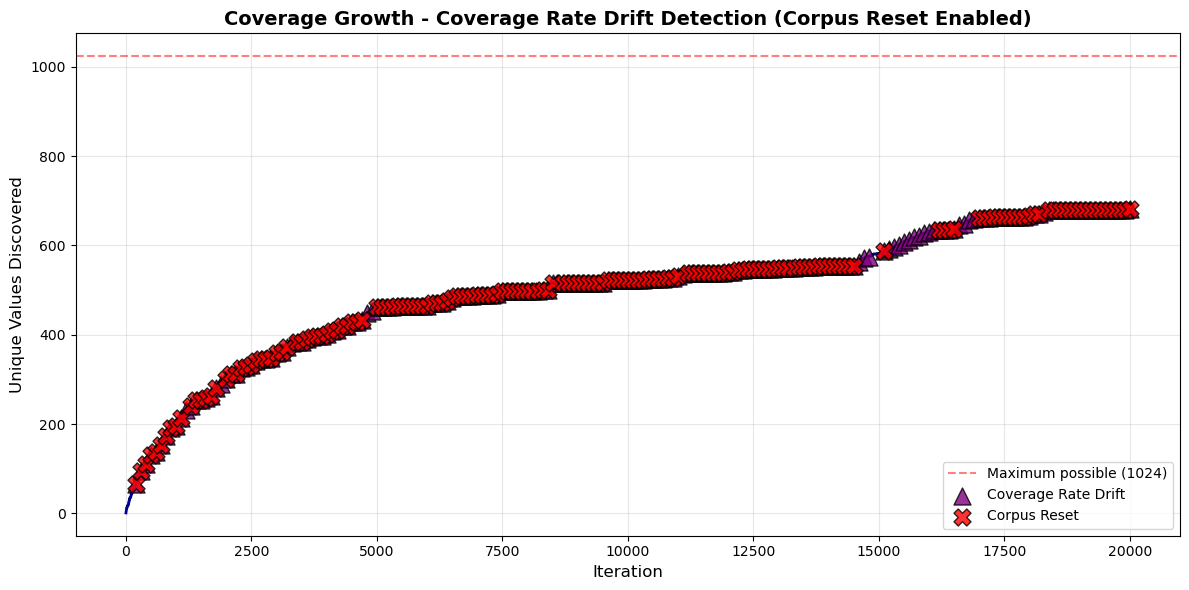

In [167]:
# Test the coverage rate fuzzer
print("=" * 80)
print("Testing Coverage Rate Drift Detection Fuzzer")
print("=" * 80)
coverage_rate_fuzzer = CoverageRateFuzzer(n=10, max_ops_per_sequence=5, reset_on_drift=True)
coverage_rate_fuzzer.fuzz(iterations=20000, random_seed=42)
coverage_rate_fuzzer.plot_coverage()

## Comparison: Coverage Rate vs Value Distribution Drift Detection

Compare the two drift detection methods across multiple seeds:

In [168]:
def run_drift_method_comparison(n_seeds=20, n_bits=10, max_ops=5, n_iterations=20000, verbose=True):
    """
    Compare value distribution drift vs coverage rate drift detection across multiple seeds.
    
    Args:
        n_seeds: Number of different random seeds to test
        n_bits: Size of bit array
        max_ops: Maximum operations per sequence
        n_iterations: Number of fuzzing iterations per run
        verbose: Whether to print progress
        
    Returns:
        pandas.DataFrame with results for each seed
    """
    results = []
    
    if verbose:
        print("=" * 80)
        print(f"Comparing Drift Detection Methods: {n_seeds} seeds")
        print(f"Parameters: n_bits={n_bits}, max_ops={max_ops}, iterations={n_iterations}")
        print("=" * 80)
    
    for seed in range(n_seeds):
        if verbose:
            print(f"\nSeed {seed + 1}/{n_seeds}: {seed}")
            print("-" * 40)
        
        # Run with VALUE DISTRIBUTION drift detection
        fuzzer_value = OperationBasedFuzzer(n=n_bits, max_ops_per_sequence=max_ops, reset_on_drift=True)
        fuzzer_value.fuzz(iterations=n_iterations, random_seed=seed)
        
        # Run with COVERAGE RATE drift detection
        fuzzer_coverage_rate = CoverageRateFuzzer(n=n_bits, max_ops_per_sequence=max_ops, reset_on_drift=True)
        fuzzer_coverage_rate.fuzz(iterations=n_iterations, random_seed=seed)
        
        # Store results
        results.append({
            'seed': seed,
            'value_dist_coverage': len(fuzzer_value.coverage),
            'cov_rate_coverage': len(fuzzer_coverage_rate.coverage),
            'value_dist_drifts': len(fuzzer_value.drift_points),
            'cov_rate_drifts': len(fuzzer_coverage_rate.drift_points),
            'value_dist_resets': len(fuzzer_value.corpus_resets),
            'cov_rate_resets': len(fuzzer_coverage_rate.corpus_resets),
            'value_dist_corpus_size': len(fuzzer_value.corpus),
            'cov_rate_corpus_size': len(fuzzer_coverage_rate.corpus),
            'coverage_diff': len(fuzzer_coverage_rate.coverage) - len(fuzzer_value.coverage)
        })
        
        if verbose:
            print(f"  Value Dist:   Coverage={len(fuzzer_value.coverage)}/{2**n_bits}, "
                  f"Drifts={len(fuzzer_value.drift_points)}, Resets={len(fuzzer_value.corpus_resets)}")
            print(f"  Coverage Rate: Coverage={len(fuzzer_coverage_rate.coverage)}/{2**n_bits}, "
                  f"Drifts={len(fuzzer_coverage_rate.drift_points)}, Resets={len(fuzzer_coverage_rate.corpus_resets)}")
            print(f"  Difference: {results[-1]['coverage_diff']:+d}")
    
    # Create DataFrame
    df_results = pd.DataFrame(results)
    
    if verbose:
        print("\n" + "=" * 80)
        print("EXPERIMENT COMPLETE")
        print("=" * 80)
    
    return df_results

In [169]:
def print_drift_comparison_summary(df_results, n_bits=10):
    """
    Print detailed summary comparing drift detection methods.
    
    Args:
        df_results: DataFrame with comparison results
        n_bits: Number of bits (for calculating percentages)
    """
    n_seeds = len(df_results)
    
    print("\nDETAILED RESULTS TABLE")
    print("=" * 80)
    
    # Create display columns
    display_df = df_results[[
        'seed', 
        'value_dist_coverage', 
        'cov_rate_coverage', 
        'coverage_diff',
        'value_dist_drifts',
        'cov_rate_drifts',
        'value_dist_resets',
        'cov_rate_resets'
    ]].copy()
    
    display_df.columns = [
        'Seed', 
        'Value Dist Cov', 
        'Cov Rate Cov', 
        'Diff',
        'Drifts (Val)', 
        'Drifts (Rate)',
        'Resets (Val)',
        'Resets (Rate)'
    ]
    
    print(display_df.to_string(index=False))
    
    print("\n" + "=" * 80)
    print("SUMMARY STATISTICS")
    print("=" * 80)
    
    # Calculate summary statistics
    print(f"\nCoverage (Value Distribution Drift):")
    print(f"  Mean:   {df_results['value_dist_coverage'].mean():.2f}")
    print(f"  Median: {df_results['value_dist_coverage'].median():.2f}")
    print(f"  Std:    {df_results['value_dist_coverage'].std():.2f}")
    print(f"  Min:    {df_results['value_dist_coverage'].min()}")
    print(f"  Max:    {df_results['value_dist_coverage'].max()}")
    
    print(f"\nCoverage (Coverage Rate Drift):")
    print(f"  Mean:   {df_results['cov_rate_coverage'].mean():.2f}")
    print(f"  Median: {df_results['cov_rate_coverage'].median():.2f}")
    print(f"  Std:    {df_results['cov_rate_coverage'].std():.2f}")
    print(f"  Min:    {df_results['cov_rate_coverage'].min()}")
    print(f"  Max:    {df_results['cov_rate_coverage'].max()}")
    
    print(f"\nCoverage Difference (Coverage Rate - Value Dist):")
    print(f"  Mean:   {df_results['coverage_diff'].mean():.2f}")
    print(f"  Median: {df_results['coverage_diff'].median():.2f}")
    print(f"  Std:    {df_results['coverage_diff'].std():.2f}")
    
    # Count wins
    wins_cov_rate = (df_results['coverage_diff'] > 0).sum()
    wins_value_dist = (df_results['coverage_diff'] < 0).sum()
    ties = (df_results['coverage_diff'] == 0).sum()
    
    print(f"\nWin Statistics (out of {n_seeds} runs):")
    print(f"  Coverage Rate Better:   {wins_cov_rate} ({100*wins_cov_rate/n_seeds:.1f}%)")
    print(f"  Value Dist Better:      {wins_value_dist} ({100*wins_value_dist/n_seeds:.1f}%)")
    print(f"  Ties:                   {ties} ({100*ties/n_seeds:.1f}%)")
    
    print(f"\nDrift Detection Frequency:")
    print(f"  Value Dist - Mean drifts:   {df_results['value_dist_drifts'].mean():.2f}")
    print(f"  Coverage Rate - Mean drifts: {df_results['cov_rate_drifts'].mean():.2f}")
    
    print(f"\nCorpus Resets:")
    print(f"  Value Dist - Mean resets:   {df_results['value_dist_resets'].mean():.2f}")
    print(f"  Coverage Rate - Mean resets: {df_results['cov_rate_resets'].mean():.2f}")
    
    # Statistical test
    from scipy import stats as scipy_stats
    t_stat, p_value = scipy_stats.ttest_rel(
        df_results['cov_rate_coverage'], 
        df_results['value_dist_coverage']
    )
    
    print(f"\nPaired t-test:")
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value:     {p_value:.4f}")
    if p_value < 0.05:
        if df_results['coverage_diff'].mean() > 0:
            print(f"  Result: Coverage Rate drift is SIGNIFICANTLY BETTER (p < 0.05)")
        else:
            print(f"  Result: Value Distribution drift is SIGNIFICANTLY BETTER (p < 0.05)")
    else:
        print(f"  Result: No significant difference (p >= 0.05)")
    
    print("\n" + "=" * 80)

In [170]:
def plot_drift_comparison(df_results, n_bits=10):
    """
    Create visualization plots comparing drift detection methods.
    
    Args:
        df_results: DataFrame with comparison results
        n_bits: Number of bits (for calculating maximum coverage)
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Coverage comparison
    ax1 = axes[0, 0]
    x = df_results['seed']
    ax1.plot(x, df_results['value_dist_coverage'], marker='o', label='Value Distribution', 
             linewidth=2, color='orange')
    ax1.plot(x, df_results['cov_rate_coverage'], marker='s', label='Coverage Rate', 
             linewidth=2, color='purple')
    ax1.axhline(y=2**n_bits, color='red', linestyle='--', alpha=0.3, label='Maximum')
    ax1.set_xlabel('Seed', fontsize=11)
    ax1.set_ylabel('Coverage', fontsize=11)
    ax1.set_title('Coverage by Seed - Drift Method Comparison', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Coverage difference
    ax2 = axes[0, 1]
    colors = ['purple' if d > 0 else 'orange' if d < 0 else 'gray' for d in df_results['coverage_diff']]
    ax2.bar(x, df_results['coverage_diff'], color=colors, alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax2.set_xlabel('Seed', fontsize=11)
    ax2.set_ylabel('Coverage Difference\n(Coverage Rate - Value Dist)', fontsize=11)
    ax2.set_title('Coverage Improvement per Seed', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Plot 3: Drift detection frequency
    ax3 = axes[1, 0]
    x_pos = np.arange(len(df_results))
    width = 0.35
    ax3.bar(x_pos - width/2, df_results['value_dist_drifts'], width, 
            label='Value Dist', alpha=0.7, color='orange')
    ax3.bar(x_pos + width/2, df_results['cov_rate_drifts'], width, 
            label='Coverage Rate', alpha=0.7, color='purple')
    ax3.set_xlabel('Seed', fontsize=11)
    ax3.set_ylabel('Number of Drifts Detected', fontsize=11)
    ax3.set_title('Drift Detection Frequency', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Plot 4: Corpus resets comparison
    ax4 = axes[1, 1]
    ax4.bar(x_pos - width/2, df_results['value_dist_resets'], width, 
            label='Value Dist', alpha=0.7, color='orange')
    ax4.bar(x_pos + width/2, df_results['cov_rate_resets'], width, 
            label='Coverage Rate', alpha=0.7, color='purple')
    ax4.set_xlabel('Seed', fontsize=11)
    ax4.set_ylabel('Number of Corpus Resets', fontsize=11)
    ax4.set_title('Corpus Reset Frequency', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print("\nVisualization complete!")

In [171]:
# Run the drift method comparison experiment
df_drift_comparison = run_drift_method_comparison(n_seeds=20, n_bits=12, max_ops=10, n_iterations=20000)

Comparing Drift Detection Methods: 20 seeds
Parameters: n_bits=12, max_ops=10, iterations=20000

Seed 1/20: 0
----------------------------------------
Starting operation-based fuzzing for 20000 iterations...
Bit array size: 12, Max operations per sequence: 10
Target: Discover all values in [0, 4096)
Concept drift detection: Window size=100, KS threshold p-value=0.05
Corpus reset on drift: True
Random seed: 0
----------------------------------------------------------------------
Iter    14: Coverage  10/4096 (0.2%) | Found value 3
Iter    51: Coverage  20/4096 (0.5%) | Found value 63
Iter    71: Coverage  30/4096 (0.7%) | Found value 32
Iter   118: Coverage  40/4096 (1.0%) | Found value 4095
Iter   148: Coverage  50/4096 (1.2%) | Found value 1027
Iter   179: Coverage  60/4096 (1.5%) | Found value 2562
Iter   219: Coverage  70/4096 (1.7%) | Found value 511
Iter   262: Coverage  80/4096 (2.0%) | Found value 2208
Iter   298: Coverage  90/4096 (2.2%) | Found value 2568
Iter   325: Coverage 


DETAILED RESULTS TABLE
 Seed  Value Dist Cov  Cov Rate Cov  Diff  Drifts (Val)  Drifts (Rate)  Resets (Val)  Resets (Rate)
    0            2593          2616    23            59            197            56            186
    1            3231          2668  -563            43            198            40            178
    2            2927          2621  -306            45            195            44            181
    3            3168          2628  -540            24            197            24            183
    4            3090          2713  -377            22            198            21            179
    5            2874          2535  -339            58            197            57            190
    6            3137          2630  -507            17            198            16            178
    7            3055          2656  -399             5            198             5            182
    8            3056          2608  -448            53            198      

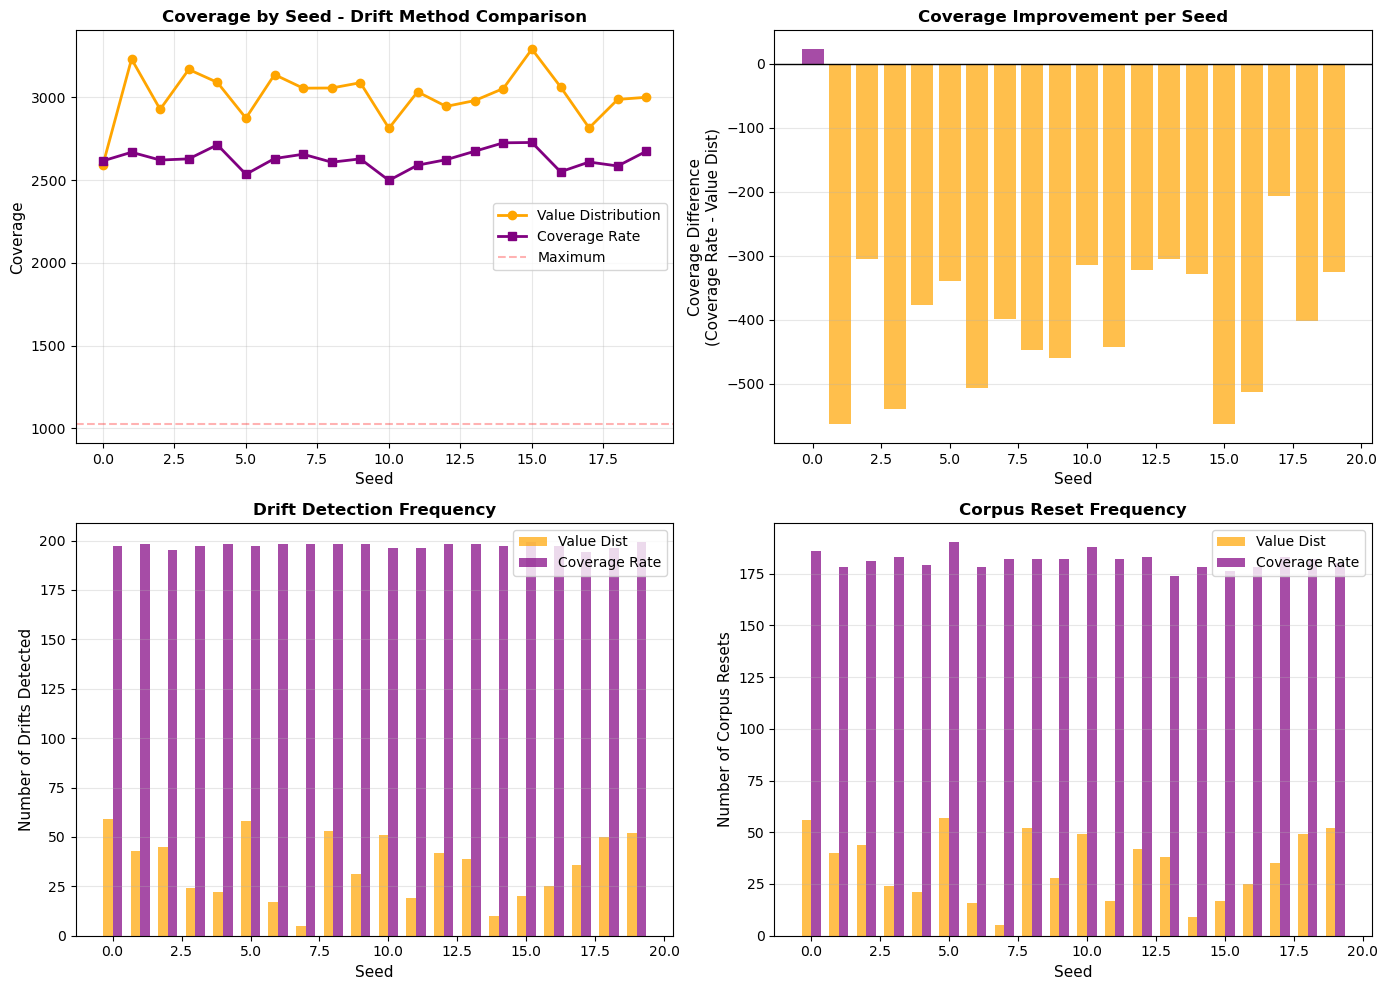


Visualization complete!


In [172]:
print_drift_comparison_summary(df_drift_comparison, n_bits=10)
plot_drift_comparison(df_drift_comparison, n_bits=10)

## Window Size Sensitivity Analysis

Test how different window sizes affect drift detection and coverage performance:

In [189]:
class ConfigurableWindowFuzzer(OperationBasedFuzzer):
    """
    Fuzzer with configurable window size for drift detection.
    Inherits from OperationBasedFuzzer but allows custom window_size.
    """
    def __init__(self, n=8, max_ops_per_sequence=10, reset_on_drift=False, window_size=100):
        super().__init__(n, max_ops_per_sequence, reset_on_drift)
        self.window_size = window_size  # Override the default window size


def run_window_size_experiment(window_sizes, n_bits=10, max_ops=5, n_iterations=20000, 
                                test_seed=42, verbose=True):
    """
    Test different window sizes on the same seed to analyze sensitivity.
    Also runs a baseline no-reset fuzzer for comparison.
    
    Args:
        window_sizes: List of window sizes to test
        n_bits: Size of bit array
        max_ops: Maximum operations per sequence
        n_iterations: Number of fuzzing iterations per run
        test_seed: Random seed to use for all runs (for fair comparison)
        verbose: Whether to print progress
        
    Returns:
        Tuple of (DataFrame with results for each window size, baseline no-reset fuzzer)
    """
    results = []
    
    if verbose:
        print("=" * 80)
        print(f"Window Size Sensitivity Analysis")
        print(f"Testing window sizes: {window_sizes}")
        print(f"Parameters: n_bits={n_bits}, max_ops={max_ops}, iterations={n_iterations}")
        print(f"Fixed seed: {test_seed}")
        print("=" * 80)
    
    # Run baseline: NO RESET fuzzer
    if verbose:
        print(f"\n{'='*80}")
        print(f"Running BASELINE: No Reset Fuzzer")
        print(f"{'='*80}")
    
    baseline_fuzzer = ConfigurableWindowFuzzer(
        n=n_bits, 
        max_ops_per_sequence=max_ops, 
        reset_on_drift=False,  # No reset baseline
        window_size=100  # Default window size
    )
    baseline_fuzzer.fuzz(iterations=n_iterations, random_seed=test_seed)
    
    if verbose:
        print(f"\nBaseline (No Reset) Summary:")
        print(f"  Coverage:      {len(baseline_fuzzer.coverage)}/{2**n_bits} "
              f"({100*len(baseline_fuzzer.coverage)/2**n_bits:.1f}%)")
        print(f"  Corpus Size:   {len(baseline_fuzzer.corpus)}")
    
    # Test different window sizes with reset enabled
    for window_size in window_sizes:
        if verbose:
            print(f"\n{'='*80}")
            print(f"Testing Window Size: {window_size} (WITH Reset)")
            print(f"{'='*80}")
        
        # Run with VALUE DISTRIBUTION drift detection
        fuzzer_value = ConfigurableWindowFuzzer(
            n=n_bits, 
            max_ops_per_sequence=max_ops, 
            reset_on_drift=True,
            window_size=window_size
        )
        fuzzer_value.fuzz(iterations=n_iterations, random_seed=test_seed)
        
        # Store results
        results.append({
            'window_size': window_size,
            'coverage': len(fuzzer_value.coverage),
            'drifts_detected': len(fuzzer_value.drift_points),
            'corpus_resets': len(fuzzer_value.corpus_resets),
            'final_corpus_size': len(fuzzer_value.corpus),
            'coverage_pct': 100 * len(fuzzer_value.coverage) / (2**n_bits)
        })
        
        if verbose:
            print(f"\nWindow {window_size} Summary:")
            print(f"  Coverage:      {len(fuzzer_value.coverage)}/{2**n_bits} "
                  f"({100*len(fuzzer_value.coverage)/2**n_bits:.1f}%)")
            print(f"  Drifts:        {len(fuzzer_value.drift_points)}")
            print(f"  Resets:        {len(fuzzer_value.corpus_resets)}")
            print(f"  Corpus Size:   {len(fuzzer_value.corpus)}")
    
    # Create DataFrame
    df_results = pd.DataFrame(results)
    
    if verbose:
        print("\n" + "=" * 80)
        print("EXPERIMENT COMPLETE")
        print("=" * 80)
    
    return df_results, baseline_fuzzer

In [190]:
def print_window_size_summary(df_results, baseline_fuzzer=None, n_bits=10):
    """
    Print detailed summary of window size experiment results.
    
    Args:
        df_results: DataFrame with window size experiment results
        baseline_fuzzer: Optional baseline fuzzer (no reset) for comparison
        n_bits: Number of bits (for calculating percentages)
    """
    print("\nWINDOW SIZE ANALYSIS RESULTS")
    print("=" * 80)
    
    # Show baseline first if provided
    if baseline_fuzzer is not None:
        print(f"\nBASELINE (No Reset):")
        print(f"  Coverage:      {len(baseline_fuzzer.coverage)}/{2**n_bits} "
              f"({100*len(baseline_fuzzer.coverage)/2**n_bits:.1f}%)")
        print(f"  Corpus Size:   {len(baseline_fuzzer.corpus)}")
        print(f"\n{'='*80}")
        print("WINDOW SIZE RESULTS (With Reset Enabled)")
        print("=" * 80)
    
    # Format the table nicely
    display_df = df_results[[
        'window_size', 
        'coverage',
        'coverage_pct',
        'drifts_detected',
        'corpus_resets',
        'final_corpus_size'
    ]].copy()
    
    display_df.columns = [
        'Window Size', 
        'Coverage',
        'Coverage %',
        'Drifts',
        'Resets',
        'Corpus Size'
    ]
    
    # Format coverage percentage
    display_df['Coverage %'] = display_df['Coverage %'].apply(lambda x: f"{x:.1f}%")
    
    print(display_df.to_string(index=False))
    
    print("\n" + "=" * 80)
    print("SUMMARY STATISTICS")
    print("=" * 80)
    
    print(f"\nCoverage:")
    print(f"  Best:  {df_results['coverage'].max()} (Window: {df_results.loc[df_results['coverage'].idxmax(), 'window_size']})")
    print(f"  Worst: {df_results['coverage'].min()} (Window: {df_results.loc[df_results['coverage'].idxmin(), 'window_size']})")
    print(f"  Mean:  {df_results['coverage'].mean():.2f}")
    print(f"  Std:   {df_results['coverage'].std():.2f}")
    
    if baseline_fuzzer is not None:
        baseline_cov = len(baseline_fuzzer.coverage)
        better_than_baseline = (df_results['coverage'] > baseline_cov).sum()
        print(f"  Better than baseline: {better_than_baseline}/{len(df_results)} window sizes")
    
    print(f"\nDrift Detection Frequency:")
    print(f"  Most:  {df_results['drifts_detected'].max()} drifts (Window: {df_results.loc[df_results['drifts_detected'].idxmax(), 'window_size']})")
    print(f"  Least: {df_results['drifts_detected'].min()} drifts (Window: {df_results.loc[df_results['drifts_detected'].idxmin(), 'window_size']})")
    print(f"  Mean:  {df_results['drifts_detected'].mean():.2f}")
    
    print(f"\nCorpus Resets:")
    print(f"  Most:  {df_results['corpus_resets'].max()} resets (Window: {df_results.loc[df_results['corpus_resets'].idxmax(), 'window_size']})")
    print(f"  Least: {df_results['corpus_resets'].min()} resets (Window: {df_results.loc[df_results['corpus_resets'].idxmin(), 'window_size']})")
    print(f"  Mean:  {df_results['corpus_resets'].mean():.2f}")
    
    print(f"\nFinal Corpus Size:")
    print(f"  Largest:  {df_results['final_corpus_size'].max()} (Window: {df_results.loc[df_results['final_corpus_size'].idxmax(), 'window_size']})")
    print(f"  Smallest: {df_results['final_corpus_size'].min()} (Window: {df_results.loc[df_results['final_corpus_size'].idxmin(), 'window_size']})")
    print(f"  Mean:     {df_results['final_corpus_size'].mean():.2f}")
    
    # Correlation analysis
    from scipy.stats import pearsonr, spearmanr
    
    print(f"\nCorrelations with Window Size:")
    
    corr_cov, p_cov = pearsonr(df_results['window_size'], df_results['coverage'])
    print(f"  Coverage:        r={corr_cov:.3f}, p={p_cov:.4f}")
    
    corr_drift, p_drift = pearsonr(df_results['window_size'], df_results['drifts_detected'])
    print(f"  Drifts Detected: r={corr_drift:.3f}, p={p_drift:.4f}")
    
    corr_reset, p_reset = pearsonr(df_results['window_size'], df_results['corpus_resets'])
    print(f"  Corpus Resets:   r={corr_reset:.3f}, p={p_reset:.4f}")
    
    print("\n" + "=" * 80)

In [197]:
def plot_window_size_analysis(df_results, baseline_fuzzer=None, n_bits=10):
    """
    Create visualization plots for window size sensitivity analysis.
    
    Args:
        df_results: DataFrame with window size experiment results
        baseline_fuzzer: Optional baseline fuzzer (no reset) to show as reference
        n_bits: Number of bits (for calculating maximum coverage)
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Coverage vs Window Size
    ax1 = axes[0, 0]
    ax1.plot(df_results['window_size'], df_results['coverage'], 
             marker='o', linewidth=2, markersize=8, color='darkblue', label='With Reset')
    
    # Add baseline if provided
    if baseline_fuzzer is not None:
        baseline_coverage = len(baseline_fuzzer.coverage)
        ax1.axhline(y=baseline_coverage, color='gray', linestyle='--', linewidth=2, 
                   alpha=0.7, label=f'Baseline (No Reset): {baseline_coverage}')
    
    ax1.axhline(y=2**n_bits, color='red', linestyle='--', alpha=0.3, label='Maximum')
    ax1.set_xlabel('Window Size', fontsize=11)
    ax1.set_ylabel('Coverage', fontsize=11)
    ax1.set_title('Coverage vs Window Size', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot 2: Drift Detection Frequency vs Window Size
    ax2 = axes[0, 1]
    ax2.plot(df_results['window_size'], df_results['drifts_detected'], 
             marker='s', linewidth=2, markersize=8, color='orange')
    ax2.set_xlabel('Window Size', fontsize=11)
    ax2.set_ylabel('Number of Drifts Detected', fontsize=11)
    ax2.set_title('Drift Detection Frequency vs Window Size', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Corpus Resets vs Window Size
    ax3 = axes[1, 0]
    ax3.plot(df_results['window_size'], df_results['corpus_resets'], 
             marker='^', linewidth=2, markersize=8, color='red')
    ax3.set_xlabel('Window Size', fontsize=11)
    ax3.set_ylabel('Number of Corpus Resets', fontsize=11)
    ax3.set_title('Corpus Resets vs Window Size', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Multiple metrics comparison (normalized)
    ax4 = axes[1, 1]
    # Normalize metrics to [0, 1] for comparison
    norm_coverage = df_results['coverage'] / df_results['coverage'].max()
    norm_drifts = df_results['drifts_detected'] / df_results['drifts_detected'].max() if df_results['drifts_detected'].max() > 0 else df_results['drifts_detected']
    norm_resets = df_results['corpus_resets'] / df_results['corpus_resets'].max() if df_results['corpus_resets'].max() > 0 else df_results['corpus_resets']
    
    ax4.plot(df_results['window_size'], norm_coverage, 
             marker='o', linewidth=2, label='Coverage (norm)', color='darkblue')
    ax4.plot(df_results['window_size'], norm_drifts, 
             marker='s', linewidth=2, label='Drifts (norm)', color='orange')
    ax4.plot(df_results['window_size'], norm_resets, 
             marker='^', linewidth=2, label='Resets (norm)', color='red')
    
    ax4.set_xlabel('Window Size', fontsize=11)
    ax4.set_ylabel('Normalized Value', fontsize=11)
    ax4.set_title('Normalized Metrics Comparison', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nVisualization complete!")

In [198]:
# Run window size sensitivity analysis
window_sizes = [20, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
df_window_analysis, baseline_fuzzer = run_window_size_experiment(
    window_sizes=window_sizes,
    n_bits=12,
    max_ops=10,
    n_iterations=20000,
    test_seed=42
)

Window Size Sensitivity Analysis
Testing window sizes: [20, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
Parameters: n_bits=12, max_ops=10, iterations=20000
Fixed seed: 42

Running BASELINE: No Reset Fuzzer
Starting operation-based fuzzing for 20000 iterations...
Bit array size: 12, Max operations per sequence: 10
Target: Discover all values in [0, 4096)
Concept drift detection: Window size=100, KS threshold p-value=0.05
Corpus reset on drift: False
Random seed: 42
----------------------------------------------------------------------
Iter    12: Coverage  10/4096 (0.2%) | Found value 1
Iter    29: Coverage  20/4096 (0.5%) | Found value 385
Iter    55: Coverage  30/4096 (0.7%) | Found value 148
Iter    84: Coverage  40/4096 (1.0%) | Found value 127
Iter   101: Coverage  50/4096 (1.2%) | Found value 146
Iter   142: Coverage  60/4096 (1.5%) | Found value 40
Iter   184: Coverage  70/4096 (1.7%) | Found value 18
Iter   208: Coverage  80/4096 (2.0%) | Found value 130
Iter   229: C


WINDOW SIZE ANALYSIS RESULTS

BASELINE (No Reset):
  Coverage:      2535/4096 (61.9%)
  Corpus Size:   2535

WINDOW SIZE RESULTS (With Reset Enabled)
 Window Size  Coverage Coverage %  Drifts  Resets  Corpus Size
          20      3164      77.2%      40      34           68
          50      3003      73.3%      20      16          449
         100      2977      72.7%      39      39            8
         200      2925      71.4%      47      45            0
         300      3186      77.8%      37      35          734
         400      2535      61.9%       0       0         2535
         500      2535      61.9%       0       0         2535
         600      2535      61.9%       0       0         2535
         700      3227      78.8%       6       5         2107
         800      3038      74.2%      24      24            0
         900      3131      76.4%       3       2         2391
        1000      3123      76.2%      19      18            0

SUMMARY STATISTICS

Coverage:

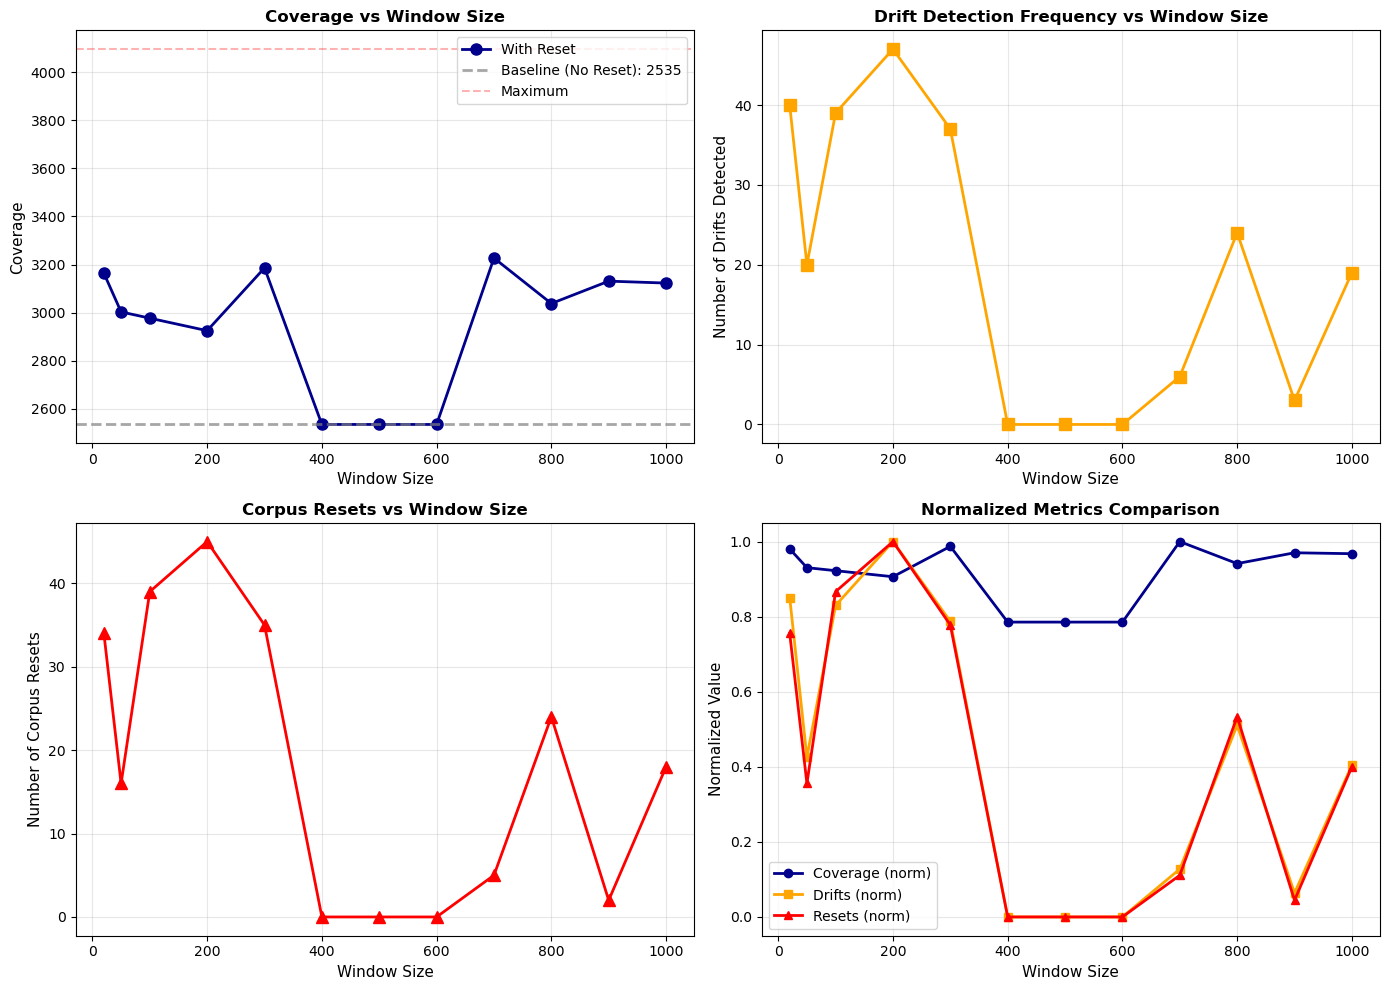


Visualization complete!


In [199]:
print_window_size_summary(df_window_analysis, baseline_fuzzer, n_bits=12)
plot_window_size_analysis(df_window_analysis, baseline_fuzzer, n_bits=12)